In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

data = pd.read_csv("./data/train.csv", encoding="UTF-8")
test = pd.read_csv("./data/test.csv", encoding="UTF-8")

In [3]:
#test 데이터 
test.loc[2,'document'] = "어린 시절 환상"

test 데이터의 2행은 영어로 되어 있기 때문에 정규식을 영어로 포함해서 적용하는 것보다 번역을 통해 넣는 것이 좋아보입니다.

In [4]:
#정규식 표현 함수
import re

def regular_expression(document):
    hangul = re.compile('[^ㄱ-ㅎ|가-힣]')
    result = hangul.sub("",document)
    return result
    

In [5]:
# data(훈련데이터), test_data(예측할 실제 데이터) 정규식 적용
data['document'] = data['document'].apply(regular_expression)
test['document'] = test['document'].apply(regular_expression)

In [6]:
#data(훈련 데이터)에 정규식이 잘 적용 되었는지 확인
data.head()

,id,document,label
0,1,영상이나음악이이쁘다해도미화시킨불륜일뿐,0
1,2,히치콕이이영화를봤다면분명박수를쳤을듯,1
2,3,괜찮은음악영화가또나왔군요따뜻한겨울이될것같아요,1
3,4,아무래도년도지난작품이라지금보기는너무유치하다,0
4,5,지금까지의영화들이그랬듯이영화역시일본에대한미화는여전하다,0


In [7]:
#test(예측 데이터) 정규식 적용 확인
test.head()

,id,document
0,1,시간때우기좋은영화지루함
1,2,훈훈한정이느껴지는영화가족끼리드라마보듯이보면딱
2,3,어린시절환상
3,4,멋있는영화입니다잊을수없는
4,5,너무감동적이네요펑펑울었습니다


In [8]:
#한국어 형태소 분석
from konlpy.tag import Okt
from collections import Counter

#말뭉치 생성
corpus ="".join(data['document'].tolist())


In [9]:
#말뭉치 정규식 적용
#regular_expression(corpus)

In [10]:
#전체 말뭉치에서 명사 형태소 추출 

okt=Okt()
nouns = okt.nouns(regular_expression(corpus))


In [11]:
#10개 확인
print(nouns[:10])

['영상', '음악', '도미', '불륜', '일', '히치콕', '이영화', '분명', '박수', '음악']


In [13]:
#단어 빈도 탐색
counter = Counter(nouns)
counter.most_common(10)

[('영화', 1339),
 ('정말', 308),
 ('진짜', 260),
 ('최고', 221),
 ('평점', 182),
 ('연기', 173),
 ('감동', 159),
 ('보고', 156),
 ('왜', 138),
 ('재미', 134)]

In [15]:
#한글자 명사 제거
available_counter = Counter({x: counter[x] for x in counter if len(x)>1})
available_counter.most_common(10)

[('영화', 1339),
 ('정말', 308),
 ('진짜', 260),
 ('최고', 221),
 ('평점', 182),
 ('연기', 173),
 ('감동', 159),
 ('보고', 156),
 ('재미', 134),
 ('스토리', 129)]

In [17]:
#불용어 사전 만들기
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [18]:
#데이터 셋에 특화된 불용어 사전 추가

movie_review_stopwords = ['지금','드라마','이야기','액션','사람','정도','내용','이건','점도','때문',
                          '이영화','용도','보지','본영']
for word in movie_review_stopwords:
    stopwords.append(word)

In [19]:
#불용어 처리
def extract_okt(text):
    test = text.lower()
    result = okt.morphs(text, stem = True)
    result = [x for x in result if x not in stopwords]
    return " ".join(result)

In [40]:
# 불용어 처리 함수 적용
from tqdm import tqdm

train_data =[]
for text in tqdm(data['document']):
    train_data.append(extract_okt(text))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.06it/s]


In [50]:
#Test 데이터 불용어 처리

test_data = []
for text in tqdm(test['document']):
    test_data.append(extract_okt(text))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:38<00:00, 128.44it/s]


In [59]:
# TF-IDF, 로지스틱 회귀분석 적용
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer()
for max_features in range(100,10000,100):
    vectorizer = TfidfVectorizer(min_df=0.0, analyzer='char',sublinear_tf=True, ngram_range=(1,3), max_features=max_features)
    
    X = np.array(train_data)
    y = np.array(data.label)
    
    X_train, X_test, y_train, y_test =  train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)
    
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    model = LogisticRegression(class_weight='balanced',C=10)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print(f"max_features: {max_features}, Accuracy: {model.score(X_test, y_test)}" )

max_features: 100, Accuracy: 0.6806666666666666
max_features: 200, Accuracy: 0.7233333333333334
max_features: 300, Accuracy: 0.7553333333333333
max_features: 400, Accuracy: 0.776
max_features: 500, Accuracy: 0.7746666666666666
max_features: 600, Accuracy: 0.782
max_features: 700, Accuracy: 0.796
max_features: 800, Accuracy: 0.804
max_features: 900, Accuracy: 0.8066666666666666
max_features: 1000, Accuracy: 0.8126666666666666
max_features: 1100, Accuracy: 0.816
max_features: 1200, Accuracy: 0.8206666666666667
max_features: 1300, Accuracy: 0.8273333333333334
max_features: 1400, Accuracy: 0.828
max_features: 1500, Accuracy: 0.832
max_features: 1600, Accuracy: 0.8293333333333334
max_features: 1700, Accuracy: 0.8293333333333334
max_features: 1800, Accuracy: 0.83
max_features: 1900, Accuracy: 0.8286666666666667
max_features: 2000, Accuracy: 0.8293333333333334
max_features: 2100, Accuracy: 0.83
max_features: 2200, Accuracy: 0.8273333333333334
max_features: 2300, Accuracy: 0.8286666666666667
m

In [56]:
#max-feature = 4600 적용

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_features=7200)
X = vectorizer.fit_transform(train_data)
y = data[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
model=LogisticRegression(class_weight='balanced', C=10)
model.fit(X_train,y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
print("Train Data 모델 score",model.score(X_train, y_train))
print("Test Data 모델 score", model.score(X_test, y_test))


#test_data = vectorizer.fit_transform(test['document'])
#print(tf_idf_vect.shape)
#print(test_data.shape)

Train Data 모델 score 0.9762857142857143
Test Data 모델 score 0.8533333333333334


In [57]:
#grid Search - 최적의 하이퍼 파라미터 찾기
from sklearn.model_selection import GridSearchCV
param_grid = {"C":[0.0001,0.001,0.01,0.1,1,10,100]}
grid_search = GridSearchCV(model, param_grid,cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameter : {}".format(grid_search.best_params_))
print("Train Data 모델 스코어 : {:.4f}".format(grid_search.best_score_))
print("Test Data 모델 스코어 : {:.4f}".format(grid_search.score(X_test, y_test)))

Best Parameter : {'C': 10}
Train Data 모델 스코어 : 0.8520
Test Data 모델 스코어 : 0.8533


그리드 서치로 하이퍼 파라 미터를 조정 하기 전에는 train_data에서 높은 정확도를 보이지만 test_data에서 정확도가 떨어지는 것을 알 수 있다.
하지만 C=10으로 하이퍼 파라미터를 튜닝하면 Train data와 Test data에서 정화도 차이가 줄어들기 때문에 주어진 Test Set을 예측할 때 튜닝을 하는 것이 더 좋아 보인다.

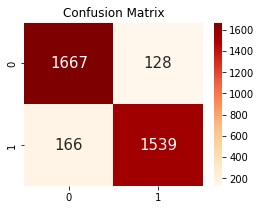

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

confusion_train = confusion_matrix(y_train, pred_train)
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_train, annot=True, annot_kws={'size':15}, cmap='OrRd', fmt='.10g')
plt.title('Confusion Matrix')
plt.show()


In [51]:
#Grid-Search 적용
test_data=vectorizer.transform(test_data)
y_pred = model.predict(test_data)


In [52]:
submission = pd.read_csv("./data/sample_submission.csv")
submission['label'] = y_pred
submission.to_csv("./data/submission(logistic).csv", index=False, header = True, encoding="UTF-8")

#0.8415

[참고문헌]
1. https://dacon.io/competitions/official/235864/codeshare/4222?page=1&dtype=recent
2. https://hyemin-kim.github.io/2020/08/29/E-Python-TextMining-2/